In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gzip, glob, os, csv
import seaborn as sns

from cdt.metrics import precision_recall, SID, SHD

mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica') 
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 20})

# import scienceplots
colormap = ["#56B4E9", "#E69F00", "#000000", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
from matplotlib.ticker import FormatStrFormatter

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [3]:
def L1(target, pred):
    return np.sum(np.abs(target - pred))

def binarize(X):
    return (X != 0) * 1

In [4]:
METHODS = ['dotears', 'notears',  'golem-nv', 'dotears_no_omega']
# METHODS = ['dotears', 'dcdi-g']

DAGS = ['chain_2', 'chain_3', 'fork_3', 'collider_3']

out_dir = '/u/home/a/asxue/project-hjp/dotears/data/small/out/'
true_dir = '/u/home/a/asxue/project-hjp/dotears/data/small/dags/'

In [5]:
df = pd.DataFrame(columns=['dag', 'method', 'sigma_1', 'beta', 'L1 dist', 'SHD'])

for method in METHODS:
    for dag in DAGS:
        w_true = np.loadtxt(os.path.join(true_dir, dag + '.txt'))
        path = os.path.join(out_dir, method, dag)
        
        for sigma_path in glob.glob(os.path.join(path, '*')):
            basename = os.path.basename(sigma_path)
            sigma1 = float(basename.split('_')[1])

            for beta_path in glob.glob(os.path.join(sigma_path, '*')):
                basename = os.path.basename(beta_path)
                beta = float(basename.split('_')[1])
                
                if beta > 1.2:
                    continue 
                    
                w_true_beta = w_true * beta
                sims = glob.glob(os.path.join(beta_path, '*'))
                
                for sim in sims:
                    w_pred = np.load(sim, allow_pickle=True)
                    l1_dist = L1(w_true_beta, w_pred)
                    w_pred[np.abs(w_pred) < 0.1 * beta] = 0
                    shd_dist = SHD(binarize(w_true), binarize(w_pred), double_for_anticausal=False)
                    df.loc[len(df.index), :] = [dag, method, sigma1, beta, l1_dist, shd_dist]
                    
                    if method == 'dcdi-g':
                        print(method, beta, sigma1, )
                        print(w_pred)



In [6]:
df['beta'].unique()

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.2, 1.1, 0.1, 0.2, 0.3, 1.0],
      dtype=object)

In [7]:
mpl.style.use('ggplot')
# plt.style.use(['science'])

plt.rcParams['lines.linewidth']= 3
plt.rcParams['axes.facecolor']= 'white'
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'

plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color']= 'black'

plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['axes.labelsize'] = 32
plt.rcParams['axes.titlesize'] = 32


plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8


plt.rcParams['text.usetex'] = False

plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.linewidth'] = 2

mpl.rc('font', family='sans-serif') 
mpl.rc('font', serif='Helvetica') 

# colormap = ['#77AADD', '#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#BBCC33', '#AAAA00', '#DDDDDD'] #light
colormap = ['#59C7EB', '#E0607E',  '#0A9086', '#FEA090', '#3E5496', '#EFDC60', '#8E2043', '#9AA0A7', '#077187', '#F5584E'] #unikn pal pref

# HUE_METHODS = ['dotears', 'gies', 'notears', 'sortnregress', 'direct-lingam', 'igsp', 'golem-nv', 'golem-ev',  ]
# # HUE_METHODS = ['dotears', 'sortnregress', 'notears', 'gies', 'golem-nv', 'igsp', 'direct-lingam', 'golem-ev']
# CV_NAME_DICT = {
#     'dotears': 'dotears*',
#     'gies': 'GIES',
#     'notears': 'NO TEARS*',
#     'sortnregress': 'sortnregress*',
#     'golem-nv': 'GOLEM-NV*',
#     'igsp': 'IGSP',
#     'direct-lingam': 'DirectLiNGAM',
#     'golem-ev': 'GOLEM-EV*'
# }


In [8]:
HUE_METHODS = ['dotears', 'gies', 'notears', 'sortnregress', 'direct-lingam', 'igsp', 'golem-nv', 'golem-ev', 'ut-igsp', 'dcdi-g']
 
DISPLAY_NAME_DICT = {
    'dotears': 'dotears',
    'gies': 'GIES',
    'notears': 'NO TEARS',
    'sortnregress': 'sortnregress',
    'golem-nv': 'GOLEM-NV',
    'igsp': 'IGSP',
    'direct-lingam': 'DirectLiNGAM',
    'golem-ev': 'GOLEM-EV',
    'dcdi-g': 'DCDI-G',
    'ut-igsp': 'UT-IGSP'
}
dags = df['dag'].unique()
methods = df['method'].unique()
sigmas = df['sigma_1'].unique()

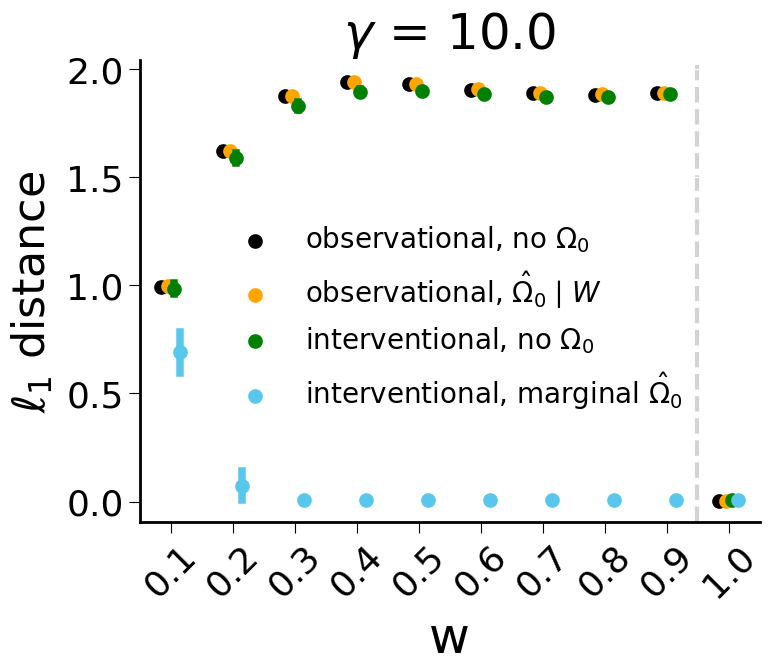

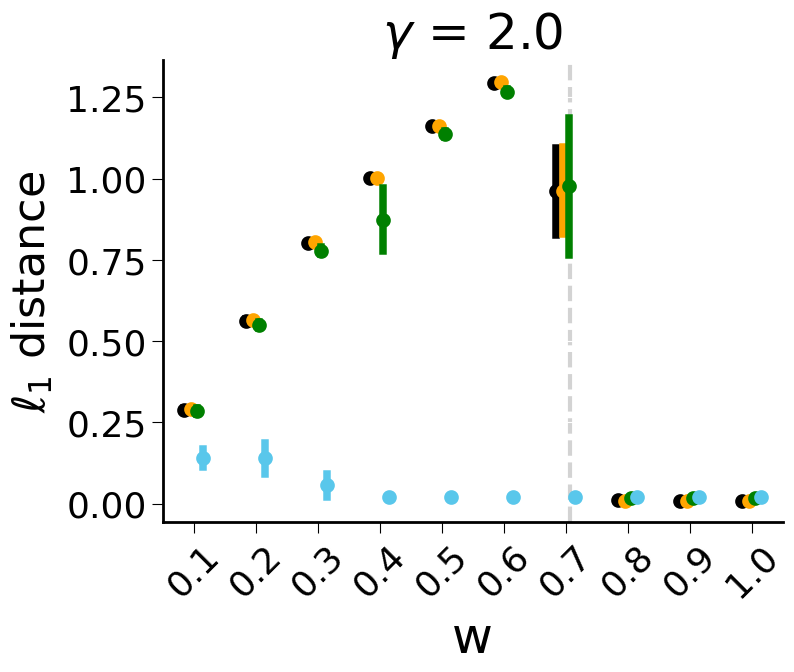

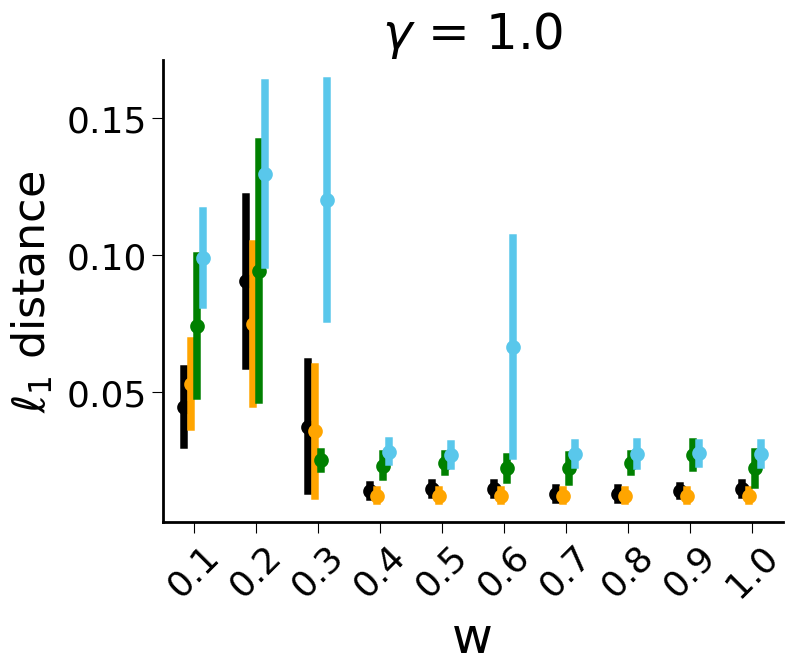

In [13]:
betas_to_keep = np.arange(0.1, 1.05, 0.1)
# betas_to_keep = np.append(betas_to_keep, 0.7)

betas_to_keep = np.round(betas_to_keep, 2).astype(np.float64)
for dag in dags:
    if dag != 'chain_2':
        continue
    for sigma in [10.0, 2.0, 1.0]:
        plt.figure(figsize=(8, 6))

        plot_df = df[(df['dag'] == dag) & 
                     (df['method'].isin(['notears', 'dotears', 'golem-nv', 'dotears_no_omega'])) & 
                     (df['sigma_1'] == sigma) & 
                     df['beta'].isin(betas_to_keep)].copy()

        plot_df['beta'] = np.round(plot_df['beta'].astype(float).values, 2)
        plot_df['L1 dist'] = np.round(plot_df['L1 dist'].astype(float).values, 2).astype(float)
#             plt.tight_layout()

        ax = plt.gca()            
        if sigma == 1:
#                 ax.axvline(10 * np.sqrt(1 - 1 / sigma), 0, 1, color='red', linestyle='--')
#                 ax.axvline(9, 0, 1, color='blue')
            pass
        else:
            ax.axvline(10 * np.sqrt(1 - 1 / sigma) - 1, 0, 1,
                       color='lightgray',
                       linestyle='--',
#                        alpha=0.7,
                       zorder=0)
#                 ax.axvline(9, 0, 1, color='blue')

        g = sns.pointplot(data=plot_df,
                          x='beta',
                          y='L1 dist',
                          hue='method',
                          palette=['black', 'orange', 'green', '#59C7EB', ],
                          hue_order=['notears', 'golem-nv', 'dotears_no_omega', 'dotears', ],
                          join=False,
                          errorbar=('se', 1),
                          scale=0.6,
                          dodge=0.3
#                           alpha=0.5
                         )

        if sigma == 100:
#             ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#             plt.yticks([0, 2, 4])
            pass
#         if sigma == 1:
#             plt.yticks([0, 0.05, 0.10])
#         if sigma == 2:
#             plt.yticks([0.0, 0.5, 1.0])
        ax.get_legend().remove()
        ax.tick_params(axis='x', which='major', labelsize=26)
        ax.tick_params(axis='y', which='major', labelsize=26)
        plt.xticks(rotation=45)
        plt.ylabel(r'$\ell_1$' + ' distance')
        plt.xlabel('w', fontsize=36)
        plt.title(r'$\gamma$ = {}'.format(sigma), fontsize=36)
#         plt.ylim(-0.05, 6)
#         sns.add_legend()
#         plt.setp(ax.collections, alpha=.5)
#             plt.savefig('../../dotears/figures/notears_p2/sigma{}.png'.format(sigma),
#                         dpi=72,
#                         bbox_inches='tight',)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        if sigma == 10:
            g.legend()

            sns.move_legend(ax, "upper left",
                            bbox_to_anchor=(0.1, 0.7),
                            frameon=False,
                            title=None,
                            fontsize=20
                           )
            for t, l in zip(g.get_legend().texts, [r'observational, no $\Omega_0$', 
                                               r'observational, $\hat{\Omega}_0 \mid W$',
                                               r'interventional, no $\Omega_0$',
                                               r'interventional, marginal $\hat{\Omega}_0$']):
                t.set_text(l)
        else:
#             sns.move_legend(ax, "upper left",
#                 bbox_to_anchor=(0.3, 0.6),
#                 frameon=False,
#                 title=None,
#                 fontsize=20
#                )
            pass

#         plt.savefig('../figures/sigma_with_dotears_{}.png'.format(sigma),
#                     bbox_inches='tight',
#                       dpi=72)

In [10]:
plot_df

,dag,method,sigma_1,beta,L1 dist,SHD
350,chain_2,dotears,1.0,1.0,0.04,0.0
351,chain_2,dotears,1.0,1.0,0.03,0.0
352,chain_2,dotears,1.0,1.0,0.03,0.0
353,chain_2,dotears,1.0,1.0,0.01,0.0
354,chain_2,dotears,1.0,1.0,0.00,0.0
...,...,...,...,...,...,...
18115,chain_2,dotears_no_omega,1.0,0.9,0.02,0.0
18116,chain_2,dotears_no_omega,1.0,0.9,0.02,0.0
18117,chain_2,dotears_no_omega,1.0,0.9,0.06,0.0
18118,chain_2,dotears_no_omega,1.0,0.9,0.01,0.0


In [11]:
df['']

KeyError: ''